In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
%reload_ext autoreload

In [1]:
import os

# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")

# then move to feature extraction
os.chdir("feature_extraction")

print(os.getcwd())

/mnt/antares_raid/home/bramantyos/codes/timescales_filtering/feature_extraction


In [2]:
from utils import load_story_info
from hard_coded_things import featuresets_dict, train_stories, test_stories

import numpy as np

from typing import Dict, List

from tqdm.notebook import trange, tqdm
from typing import Optional
from scipy.signal import periodogram, welch

import matplotlib.pyplot as plt
import seaborn as sns

from signal_processing import compute_psd, upsample_story
from utils import get_dir

KeyboardInterrupt: 

In [ ]:
from config import config_plotting

In [ ]:
config_plotting(context="paper", palette="muted")

In [ ]:
fft_size = 512
sr = 40

upsampling_method = "linear"
normalized_psd = True

is_chinese=False

aggregation_method = 'mean'

cache = ".cache/spectral_analysis/en"

In [ ]:
if not os.path.exists(cache):
    os.makedirs(cache)

In [ ]:
all_stories = train_stories + test_stories

# Upsampling Stories

In [ ]:
grid_dir, trfile_dir = get_dir(is_chinese=False)

In [ ]:

story_data_bert_en= {}
for s in all_stories:
    story_data_bert_en[s] = upsample_story(
        s,
        new_sr=sr,
        upsampling_method=upsampling_method,
        story_grid_dir=grid_dir,
        story_trfile_dir=trfile_dir,
        featureset_name="BERT_all",
        cache=cache
    )

In [ ]:
story_data_mbert_en= {}
for s in all_stories:
    story_data_mbert_en[s] = upsample_story(
        s,
        new_sr=sr,
        upsampling_method=upsampling_method,
        story_grid_dir=grid_dir,
        story_trfile_dir=trfile_dir,
        featureset_name="mBERT_all",
        cache=cache
    )

# Spectral Density Analysis

In [ ]:
def compute_psd_per_channel(story_data: dict, story_list: List = train_stories):
    n_neurons = story_data_bert_en[train_stories[0]]['story_data'].shape[1]
    psds = np.zeros((n_neurons, fft_size // 2 + 1))
    f = None
    for n in trange(n_neurons):
        # join for all stories
        joint_data = np.concatenate([story_data[s]['story_data'][:, n] for s in story_list])
        # compute periodogram
        f, psds[n] = welch(joint_data, fs=sr, nperseg=fft_size, return_onesided=True)
        
    return f, psds

In [ ]:
f, bert_periodograms = compute_psd_per_channel(story_data_bert_en, story_list = all_stories)
f, mbert_periodograms = compute_psd_per_channel(story_data_mbert_en, story_list = all_stories)

  0%|          | 0/9984 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 2)

In [ ]:
# aggregate periodograms
def aggregate_periodograms(periodograms: np.ndarray, aggregation_method: str = 'mean'):
    if aggregation_method == 'mean':
        return periodograms.mean(axis=0)
    elif aggregation_method == 'median':
        return np.median(periodograms, axis=0)
    else:
        raise ValueError("Invalid aggregation method")

In [ ]:
agg_bert_periodograms = aggregate_periodograms(bert_periodograms, aggregation_method=aggregation_method)
agg_mbert_periodograms = aggregate_periodograms(mbert_periodograms, aggregation_method=aggregation_method)

In [35]:

def plot_psds(
    first_psd: np.ndarray,
    second_psd: np.ndarray,
    f :np.ndarray,
    ax=None,
    normalized: bool = False,
    labels: List[str] = ["first", "second"],
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    first_max_val = 1
    second_max_val = 1

    if normalized:
        first_max_val = np.max(first_psd)
        second_max_val = np.max(second_psd)

    freqs = np.linspace(0, sr / 2, fft_size // 2 + 1)


    sns.lineplot(
        x=freqs[1:],
        y=first_psd[1:] / first_max_val,
        ax=ax,
        label=f"{labels[0]}",
    )
    sns.lineplot(
        x=freqs[1:],
        y=second_psd[1:] / second_max_val,
        ax=ax,
        label=f"{labels[1]}",
    )

    ax.set_xscale("log")

    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Power")

    plt.legend()
    plt.show()

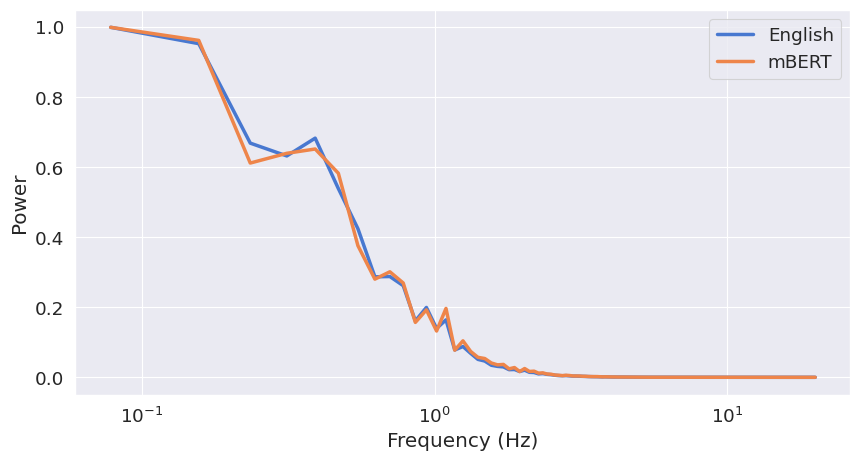

In [36]:
plot_psds(agg_bert_periodograms, agg_mbert_periodograms, normalized=normalized_psd, labels=["English", "mBERT"])

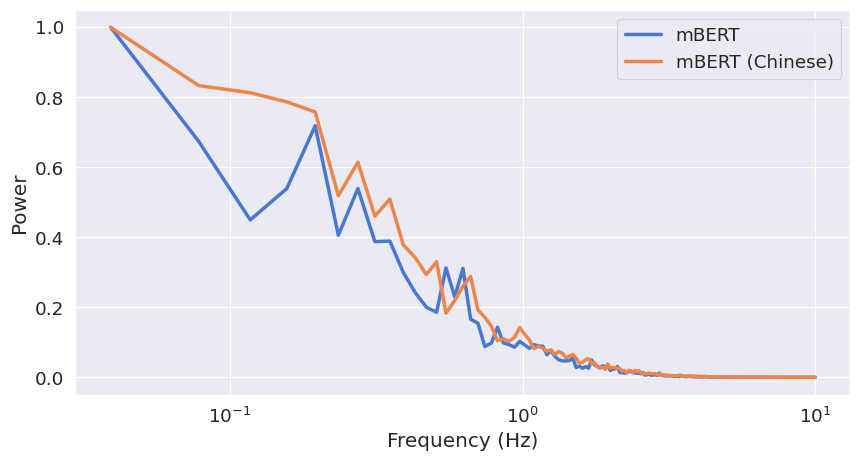

In [ ]:
plot_psds(
    psd_en_m, psd_zh_m, normalized=normalized_psd, labels=["mBERT", "mBERT (Chinese)"]
)

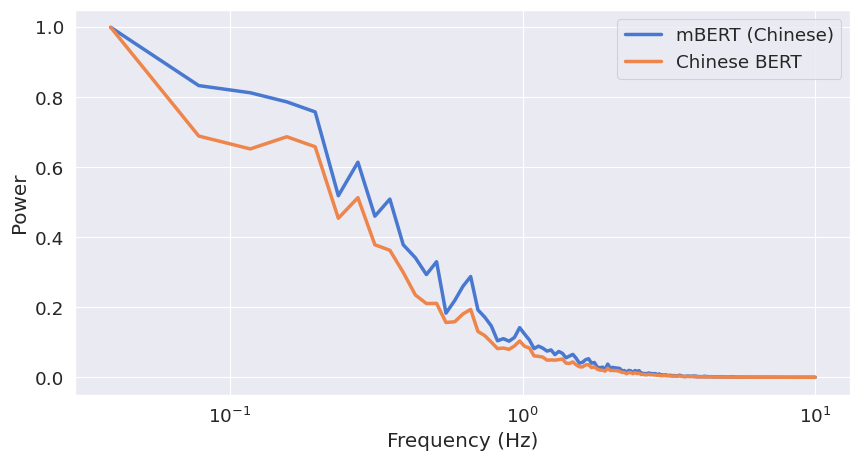

In [ ]:
plot_psds(
    psd_zh_m,
    psd_zh_zh,
    normalized=normalized_psd,
    labels=["mBERT (Chinese)", "Chinese BERT"],
)